In [1]:
import torch
import sys
sys.path.insert(0, '../scripts/')
from models import model_dict
from dataset import Galaxy10DECalsTest
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from e2cnn import nn as e2cnn_nn
import numpy as np
import torch.nn as nn

device = ('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
 ## have to write different one for densenet

In [2]:
test_data = Galaxy10DECalsTest('/Users/snehpandya/Projects/GCNNMorphology/data/test_data.hdf5', transform=transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
images, labels, angles, redshift = next(iter(test_loader))

In [3]:
model_str = 'D8'
model = model_dict[model_str]()
model.load_state_dict(torch.load(f'/Users/snehpandya/Projects/GCNNMorphology/data/final_models/{model_str}.pt', map_location=device))

/Users/snehpandya/venv-ml/lib/python3.9/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  full_mask[mask] = norms.to(torch.uint8)


<All keys matched successfully>

In [4]:
model_str = 'ResNet18'
model_2 = model_dict[model_str]()
model_2.load_state_dict(torch.load(f'/Users/snehpandya/Projects/GCNNMorphology/data/final_models/{model_str}.pt', map_location=device))

Using cache found in /Users/snehpandya/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/snehpandya/venv-ml/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/snehpandya/venv-ml/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [8]:
def generate_rotations(image: torch.tensor):
    image_90 = torch.rot90(image, dims=(2,3))
    image_180 = torch.rot90(image_90, dims=(2,3))
    image_270 = torch.rot90(image_180, dims=(2,3))
    images = [image, image_90, image_180, image_270]
    return images

@torch.no_grad()
def visualize_feature_maps(model, image: torch.tensor, indices=None):
    model.eval()
    model_weights, conv_layers = [], []
    model_children = list(model.children())
    
    for i in range(len(model_children)):
        
        if type(model_children[i]) == nn.Conv2d or type(model_children[i]) == e2cnn_nn.R2Conv:
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
           
        elif type(model_children[i]) == nn.Sequential:            
            for j in range(len(model_children[i])):
                for child in model_children[i][j].children():
                    if type(child) == nn.Conv2d or type(child) == e2cnn_nn.R2Conv:
                        model_weights.append(child.weight)
                        conv_layers.append(child)
                        
        elif type(model_children[i]) == e2cnn_nn.SequentialModule:            
            children_list = list(model_children[i].children()) 
            for j in range(len(children_list)):
                if type(children_list[j]) == e2cnn_nn.R2Conv:
                    model_weights.append(children_list[j].weights)
                    conv_layers.append(children_list[j].export())
                
    model_weights, conv_layers = np.asarray(model_weights), np.asarray(conv_layers)
    
    assert len(conv_layers) == len(model_weights), "Number of conv layers and weights do not match"
    
    outputs = []
    names = []
    image_list = generate_rotations(image)
    image_list = [image.squeeze() for image in image_list]
    
    for images in image_list:
        for layer in conv_layers:
            # images = e2cnn_nn.GeometricTensor(images, layer.in_type)
            images = layer(images)
            outputs.append(images)
            names.append(str(layer))
    
    
    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale)
       
    if indices is not None:
        processed = [processed[i] for i in indices] + [processed[i+17] for i in indices]
        
    num_rows = 4
    num_cols = int(len(processed) / num_rows)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8))
    
    labels = ['0, 90, 180, 270']
    for i, ax in enumerate(axes.flatten()):
        j = 0
        if i < len(images):
            ax.imshow(processed[i], cmap='viridis')
            ax.axis('off')
            
            if i % num_cols == 0:
                ax.set_xlabel(f"{labels[j]} degrees", fontsize=14)
                j += 1
        else:
            ax.axis('off')

    fig.subplots_adjust(hspace=0, wspace=0)
    # plt.legend()
    plt.show()


/var/folders/pf/33l4yz9171b8fsbj1vymxs8m0000gn/T/ipykernel_36732/1929031503.py:34: FutureWarning: The input object of type 'Parameter' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Parameter', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  model_weights, conv_layers = np.asarray(model_weights), np.asarray(conv_layers)
/var/folders/pf/33l4yz9171b8fsbj1vymxs8m0000gn/T/ipykernel_36732/1929031503.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model_weights, conv_laye

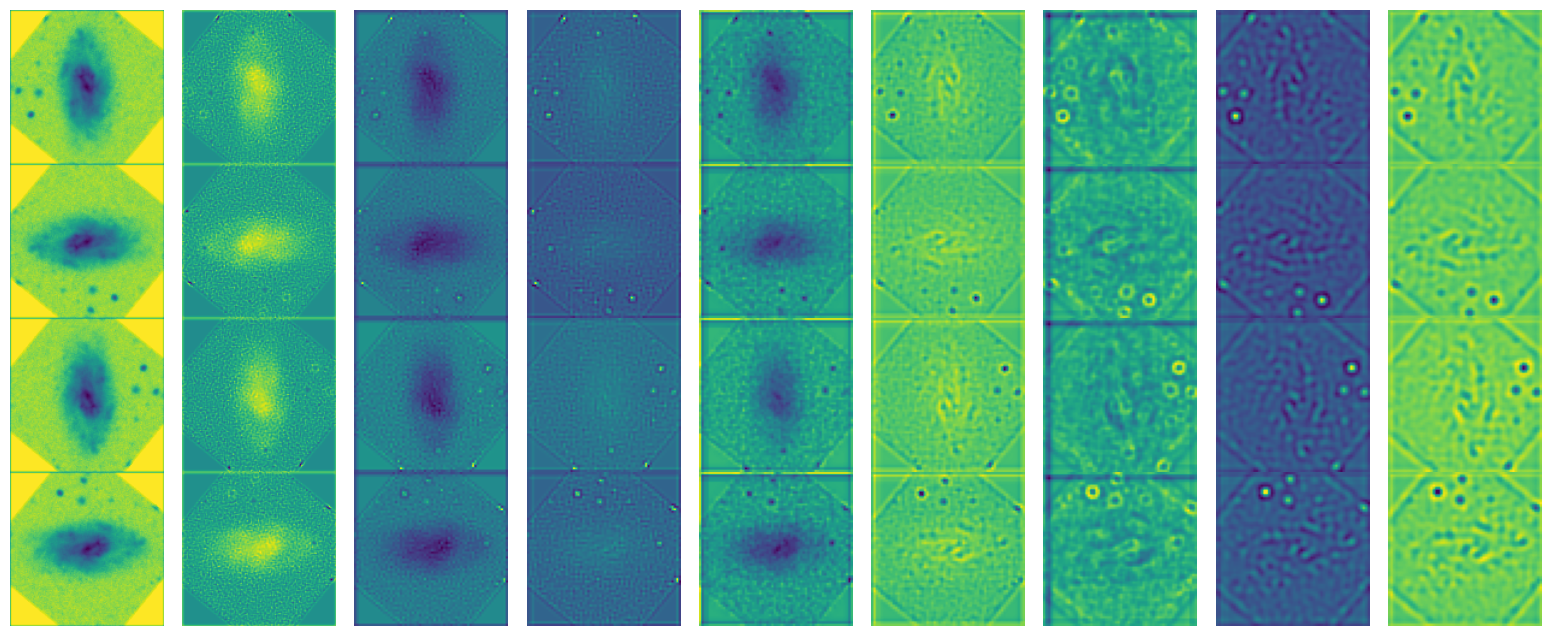

In [9]:
visualize_feature_maps(model, images)

/var/folders/pf/33l4yz9171b8fsbj1vymxs8m0000gn/T/ipykernel_36732/1647255651.py:34: FutureWarning: The input object of type 'Parameter' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Parameter', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  model_weights, conv_layers = np.asarray(model_weights), np.asarray(conv_layers)
/var/folders/pf/33l4yz9171b8fsbj1vymxs8m0000gn/T/ipykernel_36732/1647255651.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model_weights, conv_laye

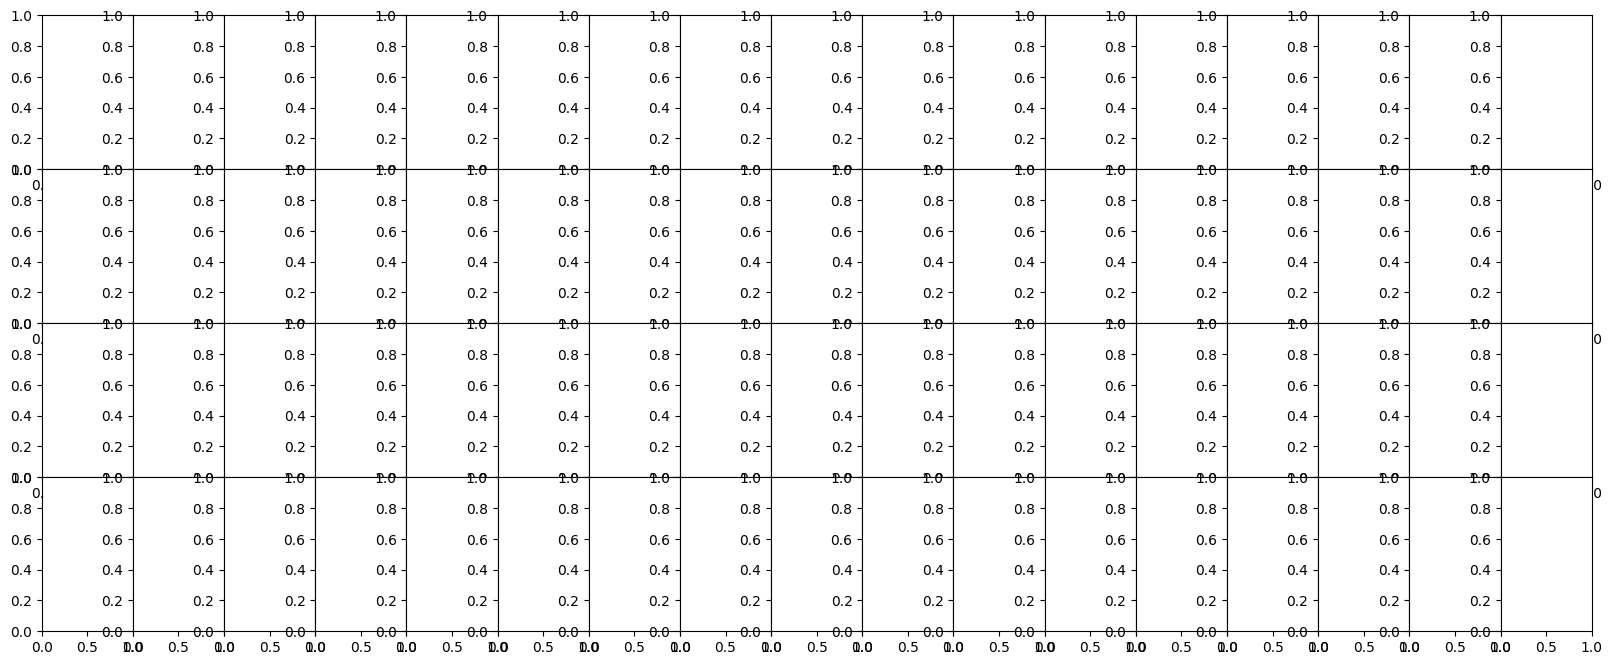

In [7]:
visualize_feature_maps(model_2, images)